<a href="https://colab.research.google.com/github/tlsdmswn01/PyTorch_Study/blob/main/MNIST_%EB%B6%84%EB%A5%98_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Torchvision : 토치비전은 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지  
- 링크: https://pytorch.org/docs/stable/torchvision/index.html

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

In [3]:
use_cuda = torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')
print(device)

cuda


In [4]:
# 랜덤 시드 고정
random.seed(777)
torch.manual_seed(777)
if device=='cuda':
  torch.cuda.manual_seed_all(777)

In [5]:
#hyperparameters
epochs=15
batch_size=100

### MNIST 데이터 불러오기

In [6]:
#MNIST dataset
mnist_train=dsets.MNIST(root='MNIST_data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True) # 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다

mnist_test=dsets.MNIST(root='MNIST_data/',
                       train=False, # 테스트 데이터 다운로드
                       transform=transforms.ToTensor(),
                       download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 112108331.99it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40177676.23it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30651470.98it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4231570.14it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [7]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
# dataloader
data_loader=DataLoader(mnist_train,batch_size,shuffle=True,drop_last=True)
#shuffle : 매 에포크마다 미니 배치를 셔플할 것인지의 여부
#drop_last: 마지막 배치를 버릴 것인지 의미
#drop_last를 하는 이유 : 만약 데이터의 총 개수가 1000이고, 배치가 128이라면 마지막 배치가 104로 남는데 이를 없애는 것 ->
# 다른 미니 배치보다 개수가 적은 마지막 배치를 경사하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막는다.

### Linear 모델로 학습시키기

In [9]:
class MultiLinear(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear=nn.Linear(28*28,10, bias=True).to(device)

  def forward(self,x):
    return self.linear(x)

model= MultiLinear()

In [10]:
# 비용함수와 옵티마이저 정의
cri=nn.CrossEntropyLoss().to(device) # 내부적으로 softmax 함수를 포함하고 있다
optimizer=torch.optim.SGD(model.parameters(),lr=1e-5)

In [11]:
for epoch in range(epochs):
  avg_cost=0
  total_batch=len(data_loader)
  for idx,samples in enumerate(data_loader):
    x_train,y_train=samples

    x_train=x_train.view(-1,28*28).to(device)
    y_train=y_train.to(device)

    prediction=model(x_train)
    cost=cri(prediction,y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost += cost/total_batch

  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))



Epoch: 0001 cost = 2.287675381
Epoch: 0002 cost = 2.281183720
Epoch: 0003 cost = 2.274734259
Epoch: 0004 cost = 2.268328667
Epoch: 0005 cost = 2.261963844
Epoch: 0006 cost = 2.255640507
Epoch: 0007 cost = 2.249355793
Epoch: 0008 cost = 2.243109465
Epoch: 0009 cost = 2.236901760
Epoch: 0010 cost = 2.230732679
Epoch: 0011 cost = 2.224599123
Epoch: 0012 cost = 2.218501806
Epoch: 0013 cost = 2.212440252
Epoch: 0014 cost = 2.206413269
Epoch: 0015 cost = 2.200421095


tensor([False,  True,  True,  ...,  True, False, False], device='cuda:0')
Accuracy: 0.22739998996257782
Prediciton:  9


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


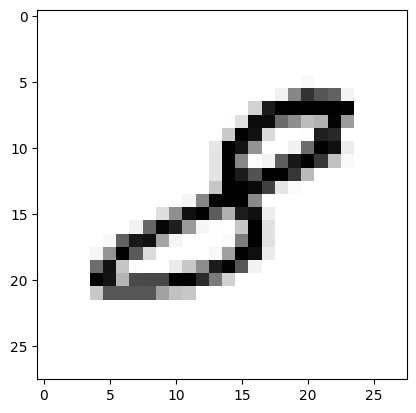

In [12]:
# 테스트 데이터를 사용해 모델을 테스트 한다
with torch.no_grad():
  x_test = mnist_test.test_data.view(-1,28*28).float().to(device)
  y_test = mnist_test.test_labels.to(device)

  prediction=model(x_test)
  cor_p=torch.argmax(prediction,1) ==y_test
  accuracy= cor_p.float().mean()
  print(cor_p)
  print('Accuracy:',accuracy.item())

  r= random.randint(0,len(mnist_test)-1)
  x_single_data=mnist_test.test_data[r:r+1].view(-1,28*28).float().to(device)
  y_single_data=mnist_test.test_labels[r:r+1].to(device)

  single_p=model(x_single_data)
  print('Prediciton: ',torch.argmax(single_p,1).item())

  plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
  plt.show()

### CNN 모델로 학습시키기

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
  torch.cuda.manual_seed_all(777)
print(device)

cuda


In [15]:
# hyperparameter 설정
lr=0.001
batch_size=100
num_classes=10
epochs=5

In [16]:
#MNIST 데이터 로드
mnist_train=dsets.MNIST(root='./data/MNIST',
                        train=True,
                        transform=transforms.ToTensor(),
                        download=True)
mnist_test=dsets.MNIST(root='/data/MNIST',
                       train=False,
                       transform=transforms.ToTensor(),
                       download=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 116863176.84it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31928227.15it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31299432.91it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6614766.93it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 116193640.39it/s]

Extracting /data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 8910967.62it/s]


Extracting /data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30923938.24it/s]


Extracting /data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5783402.78it/s]

Extracting /data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/MNIST/raw



In [17]:
train_loader=DataLoader(mnist_train, batch_size, shuffle=True, drop_last=True)
test_loader=DataLoader(mnist_test, batch_size)

In [18]:
# input size를 알기 위해서
examples=enumerate(mnist_train)
batch_idx,(example_data,example_targets)=next(examples)
example_data.shape

torch.Size([1, 28, 28])

In [21]:
class CNN(nn.Module):
  def __init__(self): # layer 정의
    super(CNN,self).__init__()

    #input 크기 : 28*28*1
    self.conv1=nn.Conv2d(1,10,kernel_size=5) # input_channel = 1, filter=10, kernel_size=5, zero_padding=0, stribe=1

    self.conv2=nn.Conv2d(10,20,kernel_size=5)

    self.drop2D= nn.Dropout2d(p=0.25, inplace=False) # 랜덤하게 뉴런을 종료해 오버피팅을 조절하는
    self.mp = nn.MaxPool2d(2)
    self.fc1=nn.Linear(320,100)
    self.fc2=nn.Linear(100,10)

  def forward(self,x):
    x=F.relu(self.mp(self.conv1(x))) # conv - 24*24*10 , mp - 12*12*10, relu
    x=F.relu(self.mp(self.conv2(x))) # conv - 8*8*20 , mp - 4*4*20, relu
    x=self.drop2D(x)
    x=x.view(x.size(0),-1) # flat
    x=self.fc1(x)
    x=self.fc2(x)
    return F.log_softmax(x)


model=CNN().to(device)
cri=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


In [22]:
# 학습하기
for epoch in range(epochs):
  avg_cost=0

  for indx,samples in enumerate(train_loader):
    x_train,y_train=samples
    x_train,y_train=x_train.to(device),y_train.to(device)
    optimizer.zero_grad()
    prediction= model(x_train)
    cost=cri(prediction,y_train)
    cost.backward()
    optimizer.step()
    avg_cost+= cost/ len(train_loader) # loss값을 변수에 누적하고 train_loader의 개수로 나눈다 = 평균을 구하는
  print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))


<ipython-input-21-28e8446b07e1>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[Epoch:    1] cost = 0.306862473
[Epoch:    2] cost = 0.112491101
[Epoch:    3] cost = 0.087559171
[Epoch:    4] cost = 0.075647898
[Epoch:    5] cost = 0.0658238828


In [40]:
# 테스트 하기
model.eval() # evaluate mode로 전환 dropout이나 batch_normalization 해제
with torch.no_grad():
  correct=0
  total=0

  for x_test, y_test in test_loader:
    x_test=x_test.to(device)
    y_test=y_test.to(device)
    out=model(x_test)
    preds=torch.max(out.data,1)[1]
    total+=len(y_test)
    correct+=(preds==y_test).sum().item() # 예측값과 실제값이 같은지 비교

  print('Test Accuracy:',100*correct/total, '%')

<ipython-input-21-28e8446b07e1>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test Accuracy: 98.68 %


In [28]:
out=model(x_test)
preds=torch.max(out.data,1)[1]
print()

tensor([8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6, 4, 1,
        9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3, 3, 9, 1, 4,
        0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3, 6, 8, 7, 1, 5, 2,
        4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6], device='cuda:0')


<ipython-input-21-28e8446b07e1>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
